In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
from models.model import initialize_model  # Import model setup function
#from save_model.model import save_model  # Import model saving function


In [3]:
# Check device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [4]:
### Step 2: Data Loading and Preprocessing
# Data Transforms (with Augmentation)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(30),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Data Paths
dataset_path = 'D:/plant_disease_detection/dataset'
train_dataset = datasets.ImageFolder(os.path.join(dataset_path, 'train'), transform=transform)
val_dataset = datasets.ImageFolder(os.path.join(dataset_path, 'val'), transform=transform)

dataloader_args = dict(batch_size=32, shuffle=True)
train_loader = DataLoader(train_dataset, **dataloader_args)
val_loader = DataLoader(val_dataset, **dataloader_args)

print(f"Training Samples: {len(train_dataset)} | Validation Samples: {len(val_dataset)}")

Training Samples: 14440 | Validation Samples: 3097


In [5]:
### Step 3: Model Initialization
num_classes = 38  # Set to 38 to match your dataset
model, criterion, optimizer = initialize_model(num_classes)


d:\conda\envs\project\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\conda\envs\project\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [6]:
### Step 4: Training the Model
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

def train_model(model, criterion, optimizer, train_loader, val_loader, epochs=10):
    model.train()
    for epoch in range(epochs):
        running_loss, correct, total = 0.0, 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_accuracy = 100 * correct / total
        train_loss = running_loss / len(train_loader)

        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        print(f"Epoch [{epoch+1}/{epochs}], Loss: {train_loss:.4f}, Accuracy: {train_accuracy:.2f}%")

train_model(model, criterion, optimizer, train_loader, val_loader, epochs=15)

Epoch [1/15], Loss: 1.0114, Accuracy: 68.33%
Epoch [2/15], Loss: 0.5802, Accuracy: 80.52%
Epoch [3/15], Loss: 0.4924, Accuracy: 83.45%
Epoch [4/15], Loss: 0.4566, Accuracy: 84.31%
Epoch [5/15], Loss: 0.4365, Accuracy: 85.28%
Epoch [6/15], Loss: 0.4199, Accuracy: 85.66%
Epoch [7/15], Loss: 0.4055, Accuracy: 86.05%
Epoch [8/15], Loss: 0.4011, Accuracy: 86.45%
Epoch [9/15], Loss: 0.3681, Accuracy: 87.64%
Epoch [10/15], Loss: 0.3717, Accuracy: 86.86%
Epoch [11/15], Loss: 0.3619, Accuracy: 87.64%
Epoch [12/15], Loss: 0.3614, Accuracy: 87.72%
Epoch [13/15], Loss: 0.3619, Accuracy: 87.88%
Epoch [14/15], Loss: 0.3580, Accuracy: 88.08%
Epoch [15/15], Loss: 0.3277, Accuracy: 89.16%


In [7]:
### Step 5: Save the Model

def save_model(model, train_losses, val_losses, train_accuracies, val_accuracies, path='models/plant_disease_model.pth'):
    torch.save({
        'model': model,
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_accuracies': train_accuracies,
        'val_accuracies': val_accuracies
    }, path)
    print(f"✅ Model saved successfully at {path}")
save_model(model, train_losses, val_losses, train_accuracies, val_accuracies)


✅ Model saved successfully at models/plant_disease_model.pth


                                             precision    recall  f1-score   support

              Pepper__bell___Bacterial_spot       0.93      1.00      0.96       150
                     Pepper__bell___healthy       0.99      0.99      0.99       222
                      Potato___Early_blight       0.96      0.94      0.95       150
                       Potato___Late_blight       0.75      0.98      0.85       150
                           Potato___healthy       1.00      0.83      0.90        23
                      Tomato_Bacterial_spot       0.92      0.97      0.94       319
                        Tomato_Early_blight       0.81      0.79      0.80       150
                         Tomato_Late_blight       0.97      0.78      0.87       286
                           Tomato_Leaf_Mold       0.92      0.90      0.91       143
                  Tomato_Septoria_leaf_spot       0.97      0.82      0.89       266
Tomato_Spider_mites_Two_spotted_spider_mite       0.94      0.90

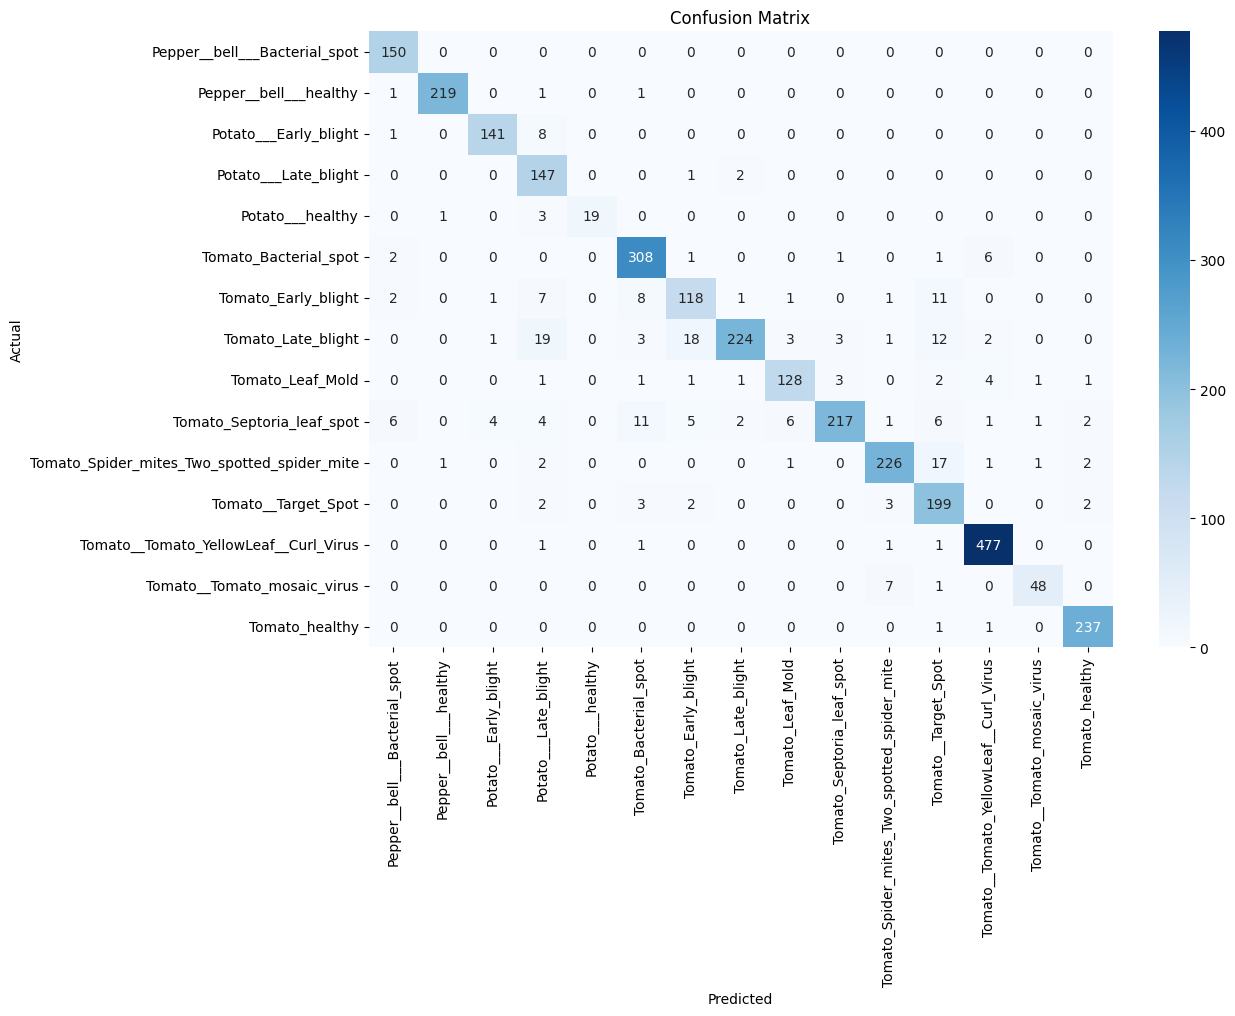

In [8]:
### Step 6: Evaluation - Classification Report and Confusion Matrix
model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# Classification Report
print(classification_report(y_true, y_pred, target_names=train_dataset.classes))

# Confusion Matrix Visualization
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=train_dataset.classes, yticklabels=train_dataset.classes)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()
